# Import necessary packages

In [34]:
# Import all required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from getpass import getuser as get_user
from getpass import getpass as get_password
from os import environ as enviroment_vars
from os import setpgrp as set_process_group
from shlex import split as cmd_split
from subprocess import Popen, PIPE, STDOUT
import pyodbc
import calendar
import seaborn as sns 
%matplotlib inline
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Create Impala connection function 

In [2]:
def impala_select(cnxn,query,show=True,sort_col=None):
    data = pd.read_sql(query,cnxn)
    if show:
        if sort_col:
            print(data.sort_values(sort_col))
        else:
            print(data)
    return data

# Create Kerberos ticket function

In [3]:
##################################################
#
#    name:   authenticate_kerberos
#    desc:   function that checks if user has a non-expired Kerberos Ticket.
#            If ticket does not exist, or it is expired, will ask 
#            for password to generate a new Kerberos Ticket. 
#            Optionally can pass "force=True" to generate a new Ticket even if existing is not expired.
#            Optionally can pass "keytab=True" to use keytab for authentication instead of typing password.
#
#            *** You should include this at beginning of every script that connects to the Hadoop Cluster! ***
#
#    args:
#            force  - (Optional) Force re-creation of Kerberos Ticket.
#            keytab - (Optional) Use Keytab for authentication instead of password.
#                                This assumes that the keytab file is in the user's  
#                                home directory with the name: <username>.keytab.
#                          
#    returns:
#            boolean - True if ticket successfully gotten, false otherwise 
#
#################################################
def authenticate_kerberos(force=False,keytab=False):
    # get username
    username = get_user()
    # get kerberos realm
    krb_realm = "MILLER.LOCAL"
    
    # create 'klist" command
    cmd = "klist"
    # create linux command process
    process = Popen(cmd_split(cmd),stdout=PIPE,stdin=PIPE, stderr=STDOUT,preexec_fn=set_process_group)
    # wait until done, get result
    result = process.communicate(None)[0].decode("utf-8") 
    
    # check that we don't already have a valid ticket
    found_username = False
    expire_date = None
    for line in result.split("\n"):
        if username in line:
            found_username = True
            # update realm if different
            krb_realm = line.split("@")[-1]
        line = line.split()
        if len(line) == 5:
            try:
                expire_date = datetime.strptime(line[2] + " " + line[3],'%m/%d/%Y %H:%M:%S')
            except (ValueError) as e:
                pass
    
    if (found_username) and (expire_date != None) and (expire_date > datetime.today()) and (not force):
        return True
    else:
        # create 'kdestory" command
        cmd = "kdestroy"
        # create linux command process
        process = Popen(cmd_split(cmd),stdout=PIPE,stdin=PIPE, stderr=STDOUT,preexec_fn=set_process_group)
        # wait until done, get result
        result = process.communicate(None)[0].decode("utf-8") 

        if keytab:
            # create "kinit" command
            cmd = "kinit -kt "+ enviroment_vars["HOME"] + "/" + username + ".keytab " + username + "@" + krb_realm
            # create linux command process
            process = Popen(cmd_split(cmd),stdout=PIPE,stdin=PIPE, stderr=STDOUT,preexec_fn=set_process_group)
            # wait until done, get result
            result = process.communicate(None)[0].decode("utf-8").strip()
            # if result
            if result.strip():
                print("Failed to obtained Kerberos Ticket via Keytab.")
                # result
                print(result)
                return False
            # ticket got successfully
            else:
                print("Successfully obtained Kerberos Ticket via Keytab.\n")
                return True
        else:
            # create "kinit" command
            cmd = "kinit " + username + "@" + krb_realm
            # create linux command process
            process = Popen(cmd_split(cmd),stdout=PIPE,stdin=PIPE, stderr=STDOUT,preexec_fn=set_process_group)
            # wait until done, get result
            result = process.communicate(get_password("Password for " + username + "@" + krb_realm + ": ").encode('utf-8'))[0].decode("utf-8").strip()
        
            # if result
            if result.strip() != "Password for " + username + "@" + krb_realm + ":":
                print("Failed to obtained Kerberos Ticket via Password.")
                # result
                print(result)
                return False
            # ticket got successfully
            else:
                print("Successfully obtained Kerberos Ticket via Password.\n")
                return True


# Create Kerberos Ticket (input your password when prompted)

In [5]:
### Run Kerberos access functions, then run Hadoop query to get data. ###
success = authenticate_kerberos(force=False)

Password for patricia.scully@MILLER.LOCAL: ········
Successfully obtained Kerberos Ticket via Password.



# Connect to Impala

In [6]:
# connect to Impala
cnxn = pyodbc.connect('DSN=Impala', autocommit=True)
cursor = cnxn.cursor()

# Define SQL query

In [7]:
#define SQL query
query = """

SELECT unique_ad_id, incr, vol, base, market, month, cast(week_start as TIMESTAMP) week_start, cast(nielsen_week_end as TIMESTAMP) nielsen_week_end, datediff(cast(nielsen_week_end as TIMESTAMP), cast(week_start as TIMESTAMP)) length_of_promo, iri_week_end, department, category, media_type, page_position, show_the_math, ad_type, ad_date, ad_grade, regions, adblock_type, event, page_number_in_ad, number_of_pages
, inpack
,case when inpack LIKE '%pk%'
then 1
else 0
end as multipack
, offer
, case 
WHEN offer LIKE '%save $%'
then offer
WHEN offer RLIKE '%'
then offer
WHEN offer LIKE '%b_g_%'
THEN ''
WHEN offer LIKE '%2/%'
THEN ''
WHEN offer LIKE '%w/purchase%'
THEN ''
else ''
end as single_unit_disc
, case
WHEN offer LIKE '%b_g_%'
then offer
WHEN offer LIKE '%2/%'
THEN offer
WHEN offer LIKE '%w/purchase%'
THEN offer
else ''
end as multi_unit_disc
, case when offer LIKE '%/$%'
then 1
else 0
end as offer_multiple
, case when offer LIKE '%w/purchase%'
then 1
else 0
end as offer_purchase
, case when offer LIKE '%limit%'
then 1
else 0
end as offer_limit
, case when offer LIKE '%b_g_%'
then 1
else 0
end as offer_buy
, case when offer RLIKE '%' 
then 1
else 0
end as offer_percent
, case when offer LIKE '%rebate%'
then 1
else 0
end as offer_rebate
, case when offer LIKE '%save $%'
then 1
else 0
end as offer_save
, case when offer LIKE '%free%'
then 1
else 0
end as offer_free
, case when offer LIKE '%digital%'
then 1
else 0
end as offer_digital
, case when offer LIKE '%coupon%'
then 1
else 0
end as offer_coupon
, case when offer LIKE '%mail in%'
then 1
else 0
end as offer_mail
from core.numerator


;
"""

# Run SQL code and pull data from Impala

In [8]:
df = impala_select(cnxn, query)

        unique_ad_id incr vol base           market           month  \
0            3003214                      miami, fl  january - 2020   
1            3003214                      miami, fl  january - 2020   
2            3003412                     tucson, az  january - 2020   
3            3003412                     tucson, az  january - 2020   
4            3003587                 birmingham, al  january - 2020   
...              ...  ...  ..  ...              ...             ...   
1182143      2578790                      tampa, fl    april - 2019   
1182144      2577788                   new york, ny    april - 2019   
1182145      2578887                los angeles, ca    april - 2019   
1182146      2578206                    houston, tx    april - 2019   
1182147      2578524                    madison, wi    april - 2019   

        week_start nielsen_week_end  length_of_promo iri_week_end  ...  \
0       2019-12-29       2020-01-11               13   2020-01-05  ...   

In [9]:
list(df)

['unique_ad_id',
 'incr',
 'vol',
 'base',
 'market',
 'month',
 'week_start',
 'nielsen_week_end',
 'length_of_promo',
 'iri_week_end',
 'department',
 'category',
 'media_type',
 'page_position',
 'show_the_math',
 'ad_type',
 'ad_date',
 'ad_grade',
 'regions',
 'adblock_type',
 'event',
 'page_number_in_ad',
 'number_of_pages',
 'inpack',
 'multipack',
 'offer',
 'single_unit_disc',
 'multi_unit_disc',
 'offer_multiple',
 'offer_purchase',
 'offer_limit',
 'offer_buy',
 'offer_percent',
 'offer_rebate',
 'offer_save',
 'offer_free',
 'offer_digital',
 'offer_coupon',
 'offer_mail']

# Create Month and Year variables

In [10]:
df['year'], df['month'] = df['nielsen_week_end'].dt.year, df['nielsen_week_end'].dt.month

In [11]:
df.head(10)

unique_ad_id     incr      vol     base              market  month  \
0      3003214                                      miami, fl      1   
1      3003214                                      miami, fl      1   
2      3003412                                     tucson, az      1   
3      3003412                                     tucson, az      1   
4      3003587                                 birmingham, al      1   
5      3003587                                 birmingham, al      1   
6      3003587                                 birmingham, al      1   
7      3003048                                    seattle, wa      1   
8      3001849  1870.03  8206.26  6336.23         phoenix, az      1   
9      3000507                             grand junction, co      1   

  week_start nielsen_week_end  length_of_promo iri_week_end  ... offer_limit  \
0 2019-12-29       2020-01-11               13   2020-01-05  ...           0   
1 2019-12-29       2020-01-11               13   2020-01-05  ...           0   
2 2019-12-29       2020-01-11               13   2020-01-05  ...           0   
3 2019-12-29       2020-01-11               13   2020-01-05  ...           0   
4 2019-12-29       2020-01-11               13   2020-01-05  ...           0   
5 2019-12-29       2020-01-11               13   2020-01-05  ...           0   
6 2019-12-29       2020-01-11               13   2020-01-05  ...           0   
7 2019-12-29       2020-01-11               13   2020-01-05  ...           0   
8 2019-12-29       2020-01-11               13   2020-01-05  ...           0   
9 2019-12-29       2020-01-11               13   2020-01-05  ...           0   

  offer_buy offer_percent offer_rebate offer_save offer_free offer_digital  \
0         0             0            0          0          0             0   
1         0             0            0          0          0             0   
2         0             0            0          1          0             0   
3         0             0            0          0          0             0   
4         0             0            0          0          0             0   
5         0             0            0          0          0             0   
6         0             0            0          0          0             0   
7         0             0            0          0          0             0   
8         0             0            0          0          0             0   
9         0             0            0          0          0             0   

  offer_coupon offer_mail  year  
0            0          0  2020  
1            0          0  2020  
2            0          0  2020  
3            0          0  2020  
4            0          0  2020  
5            0          0  2020  
6            0          0  2020  
7            0          0  2020  
8            0          0  2020  
9            0          0  2020  

[10 rows x 40 columns]

##### Convert numerical representation of month and year to categorical

In [12]:
df['month'] = [calendar.month_abbr[i] for i in df['month']]

In [13]:
df['year'] = ['year_'+str(i) for i in df['year']]

In [14]:
df.head()

unique_ad_id incr vol base          market month week_start  \
0      3003214                     miami, fl   Jan 2019-12-29   
1      3003214                     miami, fl   Jan 2019-12-29   
2      3003412                    tucson, az   Jan 2019-12-29   
3      3003412                    tucson, az   Jan 2019-12-29   
4      3003587                birmingham, al   Jan 2019-12-29   

  nielsen_week_end  length_of_promo iri_week_end  ... offer_limit offer_buy  \
0       2020-01-11               13   2020-01-05  ...           0         0   
1       2020-01-11               13   2020-01-05  ...           0         0   
2       2020-01-11               13   2020-01-05  ...           0         0   
3       2020-01-11               13   2020-01-05  ...           0         0   
4       2020-01-11               13   2020-01-05  ...           0         0   

  offer_percent offer_rebate offer_save offer_free offer_digital offer_coupon  \
0             0            0          0          0             0            0   
1             0            0          0          0             0            0   
2             0            0          1          0             0            0   
3             0            0          0          0             0            0   
4             0            0          0          0             0            0   

  offer_mail       year  
0          0  year_2020  
1          0  year_2020  
2          0  year_2020  
3          0  year_2020  
4          0  year_2020  

[5 rows x 40 columns]

##### One-hot encode month and year variables

In [15]:
df = pd.get_dummies(df, columns=['year','month'], prefix ='',prefix_sep='')

# One-hot encode the rest of the categorical vars

##### List out all the variable types

In [16]:
df.dtypes

unique_ad_id                 object
incr                         object
vol                          object
base                         object
market                       object
week_start           datetime64[ns]
nielsen_week_end     datetime64[ns]
length_of_promo               int64
iri_week_end                 object
department                   object
category                     object
media_type                   object
page_position                object
show_the_math                object
ad_type                      object
ad_date                      object
ad_grade                     object
regions                      object
adblock_type                 object
event                        object
page_number_in_ad            object
number_of_pages              object
inpack                       object
multipack                     int64
offer                        object
single_unit_disc             object
multi_unit_disc              object
offer_multiple              

##### List out non-numeric variables for easier listing

In [17]:
list(df.select_dtypes(exclude=['uint8','int64','datetime64[ns]']))

['unique_ad_id',
 'incr',
 'vol',
 'base',
 'market',
 'iri_week_end',
 'department',
 'category',
 'media_type',
 'page_position',
 'show_the_math',
 'ad_type',
 'ad_date',
 'ad_grade',
 'regions',
 'adblock_type',
 'event',
 'page_number_in_ad',
 'number_of_pages',
 'inpack',
 'offer',
 'single_unit_disc',
 'multi_unit_disc']

##### Create list from chosen categorical variables

In [18]:
cat_vars = ['market',
 'department',
 'category',
 'media_type',
 'page_position',
 'show_the_math',
 'ad_type',
 'ad_grade',
 'regions',
 'adblock_type']
 # 'event',
# 'page_number_in_ad',
# 'number_of_pages']

In [19]:
#peek at categorical variables
df[cat_vars]

market department       category            media_type  \
0              miami, fl    grocery     hard cider              circular   
1              miami, fl    grocery  domestic beer              circular   
2             tucson, az    grocery  imported beer              circular   
3             tucson, az    grocery  domestic beer              circular   
4         birmingham, al    grocery  domestic beer              circular   
...                  ...        ...            ...                   ...   
1182143        tampa, fl    grocery     craft beer              circular   
1182144     new york, ny    grocery  imported beer              circular   
1182145  los angeles, ca    grocery  imported beer              circular   
1182146      houston, tx    grocery  domestic beer  instore coupon books   
1182147      madison, wi    grocery  domestic beer              circular   

        page_position show_the_math ad_type     ad_grade      regions  \
0              middle             n       b  competitive    southeast   
1              middle             n       b  competitive    southeast   
2              middle             n       a  competitive      pacific   
3              middle             n       b  competitive      pacific   
4               front             n       b  competitive    southeast   
...               ...           ...     ...          ...          ...   
1182143          back             n       b  competitive    southeast   
1182144        middle             n       b  competitive    northeast   
1182145        middle             n       b  competitive      pacific   
1182146         front             n       a                   central   
1182147        middle             n       b  competitive  great lakes   

        adblock_type  
0              other  
1               quad  
2               quad  
3              quint  
4               quad  
...              ...  
1182143          duo  
1182144         solo  
1182145        other  
1182146         quad  
1182147         solo  

[1182148 rows x 10 columns]

##### Remove spaces and special characters from categorical variable colume values

In [20]:
for i in cat_vars:
    df[i] = df[i].astype(str).str.replace(u'\xa0', '')
    df[i] = df[i].astype(str).str.replace('!', '')
    df[i] = df[i].astype(str).str.replace(',', '')
    df[i] = df[i].astype(str).str.replace('.', '')
    df[i] = df[i].astype(str).str.replace('$', '')
    df[i] = df[i].astype(str).str.replace('(', '')
    df[i] = df[i].astype(str).str.replace(')', '')
    df[i] = df[i].astype(str).str.replace('/', '')
    df[i] = df[i].astype(str).str.replace("'", '')
    df[i] = df[i].astype(str).str.replace(' ', '_')
    df[i] = df[i].str.strip()

In [21]:
df.head()

unique_ad_id incr vol base         market week_start nielsen_week_end  \
0      3003214                     miami_fl 2019-12-29       2020-01-11   
1      3003214                     miami_fl 2019-12-29       2020-01-11   
2      3003412                    tucson_az 2019-12-29       2020-01-11   
3      3003412                    tucson_az 2019-12-29       2020-01-11   
4      3003587                birmingham_al 2019-12-29       2020-01-11   

   length_of_promo iri_week_end department  ... Dec Feb Jan Jul Jun Mar May  \
0               13   2020-01-05    grocery  ...   0   0   1   0   0   0   0   
1               13   2020-01-05    grocery  ...   0   0   1   0   0   0   0   
2               13   2020-01-05    grocery  ...   0   0   1   0   0   0   0   
3               13   2020-01-05    grocery  ...   0   0   1   0   0   0   0   
4               13   2020-01-05    grocery  ...   0   0   1   0   0   0   0   

  Nov Oct Sep  
0   0   0   0  
1   0   0   0  
2   0   0   0  
3   0   0   0  
4   0   0   0  

[5 rows x 52 columns]

##### One-hot encode categorical vars

In [22]:
for i in cat_vars:
    df = pd.get_dummies(df, columns=[i], prefix =i+'_',prefix_sep='')

In [23]:
list(df)

['unique_ad_id',
 'incr',
 'vol',
 'base',
 'week_start',
 'nielsen_week_end',
 'length_of_promo',
 'iri_week_end',
 'ad_date',
 'event',
 'page_number_in_ad',
 'number_of_pages',
 'inpack',
 'multipack',
 'offer',
 'single_unit_disc',
 'multi_unit_disc',
 'offer_multiple',
 'offer_purchase',
 'offer_limit',
 'offer_buy',
 'offer_percent',
 'offer_rebate',
 'offer_save',
 'offer_free',
 'offer_digital',
 'offer_coupon',
 'offer_mail',
 'year_2019',
 'year_2020',
 'Apr',
 'Aug',
 'Dec',
 'Feb',
 'Jan',
 'Jul',
 'Jun',
 'Mar',
 'May',
 'Nov',
 'Oct',
 'Sep',
 'market_albany_ny',
 'market_albuquerque_nm',
 'market_anaheim_ca',
 'market_anchorage_ak',
 'market_ann_arbor_mi',
 'market_appleton_wi',
 'market_athens_ga',
 'market_atlanta_ga',
 'market_atlantic_city_nj',
 'market_austin_tx',
 'market_bakersfield_ca',
 'market_baltimore_md',
 'market_barre_vt',
 'market_baton_rouge_la',
 'market_beaumont_tx',
 'market_birmingham_al',
 'market_bloomington_il',
 'market_boise_id',
 'market_boston

# Check the distribution of the vars

In [24]:
#create new df by filtering out rows with no incr values
df2 = df[(df['incr'] != '')]

In [25]:
df2['vol'] = df2['vol'].astype(float)

/jupyterhub_env/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
df2['incr'] = df2['incr'].astype(float)

/jupyterhub_env/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
df2['base'] = df2['base'].astype(float)

/jupyterhub_env/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5,0,'Vol')

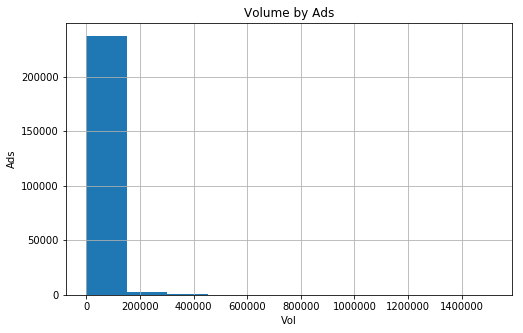

In [35]:
df2.hist('vol',figsize=(8,5))
plt.title('Volume by Ads')
plt.ylabel('Ads')
plt.xlabel("Vol")

In [29]:
df2['log_vol'] = np.log(df2['vol'])

/jupyterhub_env/lib/python3.5/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/jupyterhub_env/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
df2.head()

unique_ad_id     incr       vol      base week_start nielsen_week_end  \
8        3001849  1870.03   8206.26   6336.23 2019-12-29       2020-01-11   
93       3002347  -967.09   1175.44   2142.53 2019-12-29       2020-01-11   
108      3002226 -2819.66  30212.27  33031.93 2019-12-29       2020-01-11   
111      3000007    -7.53    755.64    763.17 2019-12-29       2020-01-11   
135      3002226  5166.20  29790.70  24624.50 2019-12-29       2020-01-11   

     length_of_promo iri_week_end     ad_date     event  ...  \
8                 13   2020-01-05  2020-01-01  no event  ...   
93                13   2020-01-05  2020-01-01  no event  ...   
108               13   2020-01-05  2020-01-01  no event  ...   
111               13   2020-01-05  2020-01-01  no event  ...   
135               13   2020-01-05  2020-01-01  no event  ...   

    regions_northeast regions_pacific regions_southeast  adblock_type_duo  \
8                   0               1                 0                 0   
93                  0               0                 0                 0   
108                 0               1                 0                 0   
111                 0               1                 0                 0   
135                 0               1                 0                 0   

    adblock_type_other adblock_type_quad adblock_type_quint  \
8                    0                 0                  1   
93                   0                 0                  1   
108                  0                 0                  1   
111                  0                 0                  1   
135                  0                 0                  1   

     adblock_type_solo  adblock_type_tri-brew    log_vol  
8                    0                      0   9.012653  
93                   0                      0   7.069398  
108                  0                      0  10.316003  
111                  0                      0   6.627565  
135                  0                      0  10.301952  

[5 rows x 290 columns]

In [31]:
df2 = df2[(df2['vol'] != 0)]

Text(0.5,0,'Log of Vol')

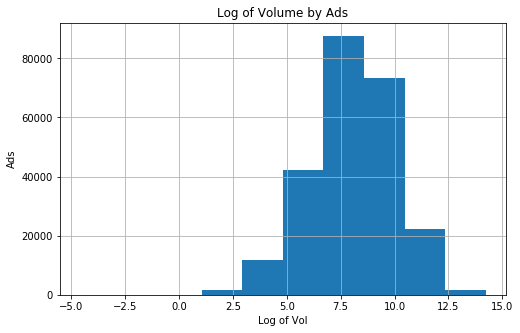

In [36]:
df2.hist('log_vol',figsize=(8,5))
plt.title('Log of Volume by Ads')
plt.ylabel('Ads')
plt.xlabel("Log of Vol")

# Log variables

##### List out the variables in df to decide on which ones to log

In [37]:
list(df2)

['unique_ad_id',
 'incr',
 'vol',
 'base',
 'week_start',
 'nielsen_week_end',
 'length_of_promo',
 'iri_week_end',
 'ad_date',
 'event',
 'page_number_in_ad',
 'number_of_pages',
 'inpack',
 'multipack',
 'offer',
 'single_unit_disc',
 'multi_unit_disc',
 'offer_multiple',
 'offer_purchase',
 'offer_limit',
 'offer_buy',
 'offer_percent',
 'offer_rebate',
 'offer_save',
 'offer_free',
 'offer_digital',
 'offer_coupon',
 'offer_mail',
 'year_2019',
 'year_2020',
 'Apr',
 'Aug',
 'Dec',
 'Feb',
 'Jan',
 'Jul',
 'Jun',
 'Mar',
 'May',
 'Nov',
 'Oct',
 'Sep',
 'market_albany_ny',
 'market_albuquerque_nm',
 'market_anaheim_ca',
 'market_anchorage_ak',
 'market_ann_arbor_mi',
 'market_appleton_wi',
 'market_athens_ga',
 'market_atlanta_ga',
 'market_atlantic_city_nj',
 'market_austin_tx',
 'market_bakersfield_ca',
 'market_baltimore_md',
 'market_barre_vt',
 'market_baton_rouge_la',
 'market_beaumont_tx',
 'market_birmingham_al',
 'market_bloomington_il',
 'market_boise_id',
 'market_boston

In [38]:
len(df2['event'].unique())

191

##### Add constant to incr column so we can log it, in case we want to use it in the model as an independent variable

In [39]:
#check min value of incr to see what constant needs to be added to make all values non-negative
min(df2['incr'])

-178724.44

In [40]:
#create new incr column with constant added
df2['incr_plus_constant'] = df2['incr'] + 200000

In [41]:
df2.head()

unique_ad_id     incr       vol      base week_start nielsen_week_end  \
8        3001849  1870.03   8206.26   6336.23 2019-12-29       2020-01-11   
93       3002347  -967.09   1175.44   2142.53 2019-12-29       2020-01-11   
108      3002226 -2819.66  30212.27  33031.93 2019-12-29       2020-01-11   
111      3000007    -7.53    755.64    763.17 2019-12-29       2020-01-11   
135      3002226  5166.20  29790.70  24624.50 2019-12-29       2020-01-11   

     length_of_promo iri_week_end     ad_date     event  ... regions_pacific  \
8                 13   2020-01-05  2020-01-01  no event  ...               1   
93                13   2020-01-05  2020-01-01  no event  ...               0   
108               13   2020-01-05  2020-01-01  no event  ...               1   
111               13   2020-01-05  2020-01-01  no event  ...               1   
135               13   2020-01-05  2020-01-01  no event  ...               1   

    regions_southeast adblock_type_duo  adblock_type_other adblock_type_quad  \
8                   0                0                   0                 0   
93                  0                0                   0                 0   
108                 0                0                   0                 0   
111                 0                0                   0                 0   
135                 0                0                   0                 0   

    adblock_type_quint adblock_type_solo  adblock_type_tri-brew    log_vol  \
8                    1                 0                      0   9.012653   
93                   1                 0                      0   7.069398   
108                  1                 0                      0  10.316003   
111                  1                 0                      0   6.627565   
135                  1                 0                      0  10.301952   

     incr_plus_constant  
8             201870.03  
93            199032.91  
108           197180.34  
111           199992.47  
135           205166.20  

[5 rows x 291 columns]

##### Make a list of all the vars you want to log

In [42]:
vars_to_log = ['base','incr_plus_constant']

##### Loop through the list and  create logged variables

In [43]:
for i in vars_to_log:
    logged_var = 'log_'+i
    df2[logged_var] = np.log(df2[i])

/jupyterhub_env/lib/python3.5/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [44]:
df2.head()

unique_ad_id     incr       vol      base week_start nielsen_week_end  \
8        3001849  1870.03   8206.26   6336.23 2019-12-29       2020-01-11   
93       3002347  -967.09   1175.44   2142.53 2019-12-29       2020-01-11   
108      3002226 -2819.66  30212.27  33031.93 2019-12-29       2020-01-11   
111      3000007    -7.53    755.64    763.17 2019-12-29       2020-01-11   
135      3002226  5166.20  29790.70  24624.50 2019-12-29       2020-01-11   

     length_of_promo iri_week_end     ad_date     event  ... adblock_type_duo  \
8                 13   2020-01-05  2020-01-01  no event  ...                0   
93                13   2020-01-05  2020-01-01  no event  ...                0   
108               13   2020-01-05  2020-01-01  no event  ...                0   
111               13   2020-01-05  2020-01-01  no event  ...                0   
135               13   2020-01-05  2020-01-01  no event  ...                0   

    adblock_type_other adblock_type_quad  adblock_type_quint  \
8                    0                 0                   1   
93                   0                 0                   1   
108                  0                 0                   1   
111                  0                 0                   1   
135                  0                 0                   1   

    adblock_type_solo adblock_type_tri-brew    log_vol  incr_plus_constant  \
8                   0                     0   9.012653           201870.03   
93                  0                     0   7.069398           199032.91   
108                 0                     0  10.316003           197180.34   
111                 0                     0   6.627565           199992.47   
135                 0                     0  10.301952           205166.20   

      log_base  log_incr_plus_constant  
8     8.754039               12.215379  
93    7.669743               12.201225  
108  10.405230               12.191874  
111   6.637481               12.206035  
135  10.111497               12.231576  

[5 rows x 293 columns]

# Model

##### First fill all NA values

In [45]:
df2 = df2.fillna(0)

In [46]:
# Make a copy of the df to work with
modeling_df = df2.copy()

##### Then find any perfectly correlated variables and drop one

In [47]:
#colliniarity between variables will affect the coefficients and potentially cause overfitting
#Check for mulitcolliniarity, first create a correlation matrix
corr_matrix = modeling_df.corr().abs()

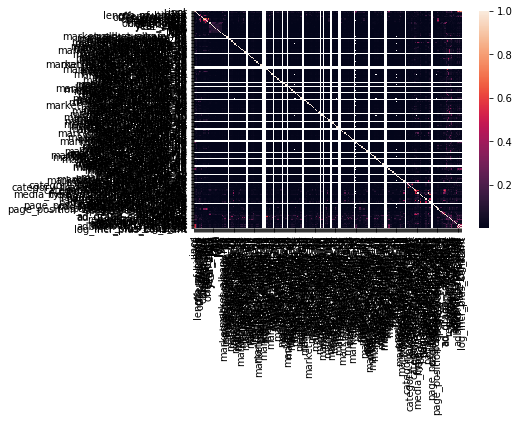

In [50]:
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns)

In [51]:
#Then select the upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of columns with perfect correlation
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]

modeling_df = modeling_df.drop(modeling_df[to_drop], axis=1)

In [52]:
#see what vars were dropped
to_drop

['year_2020', 'show_the_math_y', 'incr_plus_constant']

In [53]:
#get the length and width of the df
modeling_df.shape

(240508, 290)

##### Replace infinity values with zero

In [54]:
modeling_df.replace([np.inf, -np.inf], 0)

unique_ad_id      incr       vol      base week_start  \
8            3001849   1870.03   8206.26   6336.23 2019-12-29   
93           3002347   -967.09   1175.44   2142.53 2019-12-29   
108          3002226  -2819.66  30212.27  33031.93 2019-12-29   
111          3000007     -7.53    755.64    763.17 2019-12-29   
135          3002226   5166.20  29790.70  24624.50 2019-12-29   
...              ...       ...       ...       ...        ...   
1182118      2576261   1372.85   3492.67   2119.82 2019-04-14   
1182124      2579109  12139.76  19520.74   7380.98 2019-04-14   
1182127      2579109     71.51    207.83    136.32 2019-04-14   
1182128      2579208   1862.36   4831.21   2968.86 2019-04-14   
1182136      2577118   5130.39   7877.99   2747.60 2019-04-14   

        nielsen_week_end  length_of_promo iri_week_end     ad_date     event  \
8             2020-01-11               13   2020-01-05  2020-01-01  no event   
93            2020-01-11               13   2020-01-05  2020-01-01  no event   
108           2020-01-11               13   2020-01-05  2020-01-01  no event   
111           2020-01-11               13   2020-01-05  2020-01-01  no event   
135           2020-01-11               13   2020-01-05  2020-01-01  no event   
...                  ...              ...          ...         ...       ...   
1182118       2019-04-27               13   2019-04-21  2019-04-19  no event   
1182124       2019-04-27               13   2019-04-21  2019-04-17    easter   
1182127       2019-04-27               13   2019-04-21  2019-04-17    easter   
1182128       2019-04-27               13   2019-04-21  2019-04-17    easter   
1182136       2019-04-27               13   2019-04-21  2019-04-19  no event   

         ... regions_southeast adblock_type_duo adblock_type_other  \
8        ...                 0                0                  0   
93       ...                 0                0                  0   
108      ...                 0                0                  0   
111      ...                 0                0                  0   
135      ...                 0                0                  0   
...      ...               ...              ...                ...   
1182118  ...                 0                0                  0   
1182124  ...                 0                0                  0   
1182127  ...                 0                1                  0   
1182128  ...                 0                0                  0   
1182136  ...                 0                1                  0   

         adblock_type_quad adblock_type_quint adblock_type_solo  \
8                        0                  1                 0   
93                       0                  1                 0   
108                      0                  1                 0   
111                      0                  1                 0   
135                      0                  1                 0   
...                    ...                ...               ...   
1182118                  0                  0                 0   
1182124                  0                  0                 0   
1182127                  0                  0                 0   
1182128                  0                  0                 1   
1182136                  0                  0                 0   

        adblock_type_tri-brew    log_vol   log_base  log_incr_plus_constant  
8                           0   9.012653   8.754039               12.215379  
93                          0   7.069398   7.669743               12.201225  
108                         0  10.316003  10.405230               12.191874  
111                         0   6.627565   6.637481               12.206035  
135                         0  10.301952  10.111497               12.231576  
...                       ...        ...        ...                     ...  
1182118                     1   8.158422   7.659086               12.21291

##### Get list of variables in df for modeling

In [55]:
list(modeling_df)

['unique_ad_id',
 'incr',
 'vol',
 'base',
 'week_start',
 'nielsen_week_end',
 'length_of_promo',
 'iri_week_end',
 'ad_date',
 'event',
 'page_number_in_ad',
 'number_of_pages',
 'inpack',
 'multipack',
 'offer',
 'single_unit_disc',
 'multi_unit_disc',
 'offer_multiple',
 'offer_purchase',
 'offer_limit',
 'offer_buy',
 'offer_percent',
 'offer_rebate',
 'offer_save',
 'offer_free',
 'offer_digital',
 'offer_coupon',
 'offer_mail',
 'year_2019',
 'Apr',
 'Aug',
 'Dec',
 'Feb',
 'Jan',
 'Jul',
 'Jun',
 'Mar',
 'May',
 'Nov',
 'Oct',
 'Sep',
 'market_albany_ny',
 'market_albuquerque_nm',
 'market_anaheim_ca',
 'market_anchorage_ak',
 'market_ann_arbor_mi',
 'market_appleton_wi',
 'market_athens_ga',
 'market_atlanta_ga',
 'market_atlantic_city_nj',
 'market_austin_tx',
 'market_bakersfield_ca',
 'market_baltimore_md',
 'market_barre_vt',
 'market_baton_rouge_la',
 'market_beaumont_tx',
 'market_birmingham_al',
 'market_bloomington_il',
 'market_boise_id',
 'market_boston_ma',
 'market

In [56]:
vars_to_use = [
 'length_of_promo',
 'multipack',
 'offer_multiple',
 'offer_purchase',
 'offer_limit',
 'offer_buy',
 'offer_percent',
 'offer_rebate',
 'offer_save',
 'offer_free',
 'offer_digital',
 'offer_coupon',
 'offer_mail',
 'year_2019',
 'Apr',
 'Aug',
 'Dec',
 'Feb',
 'Jan',
 'Jul',
 'Jun',
 'Mar',
 'May',
 'Nov',
 'Oct',
 'Sep',
 'market_albany_ny',
 'market_albuquerque_nm',
 'market_anaheim_ca',
 'market_anchorage_ak',
 'market_ann_arbor_mi',
 'market_appleton_wi',
 'market_athens_ga',
 'market_atlanta_ga',
 'market_atlantic_city_nj',
 'market_austin_tx',
 'market_bakersfield_ca',
 'market_baltimore_md',
 'market_barre_vt',
 'market_baton_rouge_la',
 'market_beaumont_tx',
 'market_birmingham_al',
 'market_bloomington_il',
 'market_boise_id',
 'market_boston_ma',
 'market_bowling_green_ky',
 'market_bridgeport_ct',
 'market_brownsville_tx',
 'market_buffalo_ny',
 'market_burlington_vt',
 'market_cambridge_ma',
 'market_casper_wy',
 'market_catskill_ny',
 'market_champaign_il',
 'market_charleston_sc',
 'market_charleston_wv',
 'market_charlotte_nc',
 'market_cheyenne_wy',
 'market_chicago_il',
 'market_cincinnati_oh',
 'market_cleveland_oh',
 'market_clinton_ia',
 'market_coeur_d_alene_id',
 'market_colorado_springs_co',
 'market_columbia_mo',
 'market_columbia_sc',
 'market_columbus_oh',
 'market_concord_ca',
 'market_concord_nc',
 'market_corpus_christi_tx',
 'market_covington_ga',
 'market_covington_ky',
 'market_dallas_tx',
 'market_davenport_ia',
 'market_dayton_oh',
 'market_denver_co',
 'market_des_moines_ia',
 'market_detroit_mi',
 'market_dover_de',
 'market_duluth_mn',
 'market_easton_md',
 'market_el_paso_tx',
 'market_eugene_or',
 'market_evansville_in',
 'market_fairfax_va',
 'market_fargo_nd',
 'market_flint_mi',
 'market_florence_ky',
 'market_fort_collins_co',
 'market_fort_myers_fl',
 'market_fort_wayne_in',
 'market_fort_worth_tx',
 'market_fresno_ca',
 'market_gainesville_fl',
 'market_grand_junction_co',
 'market_grand_rapids_mi',
 'market_great_falls_mt',
 'market_green_bay_wi',
 'market_greensboro_nc',
 'market_greenville_sc',
 'market_hammond_in',
 'market_hammond_la',
 'market_harrisburg_pa',
 'market_hartford_ct',
 'market_honolulu_hi',
 'market_houston_tx',
 'market_indianapolis_in',
 'market_jackson_ms',
 'market_jacksonville_fl',
 'market_jersey_city_nj',
 'market_joliet_il',
 'market_kansas_city_ks',
 'market_kansas_city_mo',
 'market_kenosha_wi',
 'market_knoxville_tn',
 'market_lafayette_la',
 'market_lake_havasu_city_az',
 'market_lansing_mi',
 'market_laredo_tx',
 'market_las_vegas_nv',
 'market_lexington_ky',
 'market_lincoln_ne',
 'market_little_rock_ar',
 'market_los_angeles_ca',
 'market_louisville_ky',
 'market_lubbock_tx',
 'market_madison_wi',
 'market_manchester_nh',
 'market_maryville_tn',
 'market_memphis_tn',
 'market_miami_fl',
 'market_michigan_city_in',
 'market_middletown_nj',
 'market_midland_tx',
 'market_milwaukee_wi',
 'market_mineola_ny',
 'market_minneapolis_mn',
 'market_missoula_mt',
 'market_modesto_ca',
 'market_montgomery_al',
 'market_myrtle_beach_sc',
 'market_nashville_tn',
 'market_new_haven_ct',
 'market_new_orleans_la',
 'market_new_york_ny',
 'market_newark_nj',
 'market_newburgh_ny',
 'market_nicholasville_ky',
 'market_norfolk_va',
 'market_north_port_fl',
 'market_norwich_ct',
 'market_oakland_ca',
 'market_oklahoma_city_ok',
 'market_omaha_ne',
 'market_orlando_fl',
 'market_pensacola_fl',
 'market_peoria_il',
 'market_philadelphia_pa',
 'market_phoenix_az',
 'market_pittsburgh_pa',
 'market_portland_me',
 'market_portland_or',
 'market_poughkeepsie_ny',
 'market_providence_ri',
 'market_pueblo_co',
 'market_raleigh_nc',
 'market_randolph_nj',
 'market_reno_nv',
 'market_richmond_va',
 'market_riverhead_ny',
 'market_riverside_ca',
 'market_roanoke_va',
 'market_rochester_mn',
 'market_rochester_ny',
 'market_rock_springs_wy',
 'market_rockford_il',
 'market_sacramento_ca',
 'market_saint_cloud_mn',
 'market_saint_george_ut',
 'market_saint_petersburg_fl',
 'market_salt_lake_city_ut',
 'market_san_antonio_tx',
 'market_san_bernardino_ca',
 'market_san_diego_ca',
 'market_san_francisco_ca',
 'market_san_jose_ca',
 'market_santa_rosa_ca',
 'market_savannah_ga',
 'market_seattle_wa',
 'market_shreveport_la',
 'market_sioux_falls_sd',
 'market_south_bend_in',
 'market_spokane_wa',
 'market_springfield_il',
 'market_springfield_ma',
 'market_springfield_mo',
 'market_st_louis_mo',
 'market_stockton_ca',
 'market_syracuse_ny',
 'market_tampa_fl',
 'market_taylorville_il',
 'market_toledo_oh',
 'market_topeka_ks',
 'market_trenton_nj',
 'market_troy_mi',
 'market_tucson_az',
 'market_tulsa_ok',
 'market_tyler_tx',
 'market_valparaiso_in',
 'market_vancouver_wa',
 'market_virginia_beach_va',
 'market_washington_dc',
 'market_west_palm_beach_fl',
 'market_wichita_ks',
 'market_wilkes_barre_pa',
 'market_wilmington_de',
 'market_worcester_ma',
 'department_grocery',
 'category_cocktails-single_serve',
 'category_craft_beer',
 'category_domestic_beer',
 'category_flavored_malt_beverages',
 'category_hard_cider',
 'category_hard_seltzer',
 'category_imported_beer',
 'category_non-alcoholic_beer',
 'media_type_bonus_pages',
 'media_type_circular',
 'media_type_fsi',
 'media_type_instore_coupon_books',
 'media_type_newspaper_rop',
 'page_position_',
 'page_position_arts_&_life',
 'page_position_back',
 'page_position_business',
 'page_position_classified',
 'page_position_editorials',
 'page_position_food',
 'page_position_front',
 'page_position_health',
 'page_position_local_news',
 'page_position_main',
 'page_position_middle',
 'page_position_parade',
 'page_position_puzzles_&_comics',
 'page_position_real_estate',
 'page_position_sports',
 'page_position_taste',
 'page_position_weather',
 'page_position_weekly_coupon_book',
 'page_position_wrap',
 'show_the_math_n',
 'ad_type_',
 'ad_type_a',
 'ad_type_b',
 'ad_type_c',
 'ad_grade_',
 'ad_grade_competitive',
 'ad_grade_satisfactory',
 'regions_',
 'regions_central',
 'regions_great_lakes',
 'regions_northeast',
 'regions_pacific',
 'regions_southeast',
 'adblock_type_duo',
 'adblock_type_other',
 'adblock_type_quad',
 'adblock_type_quint',
 'adblock_type_solo',
 'adblock_type_tri-brew',
 'log_base']

In [57]:
print(modeling_df[list(vars_to_use)].dtypes)

length_of_promo            int64
multipack                  int64
offer_multiple             int64
offer_purchase             int64
offer_limit                int64
                          ...   
adblock_type_quad          uint8
adblock_type_quint         uint8
adblock_type_solo          uint8
adblock_type_tri-brew      uint8
log_base                 float64
Length: 272, dtype: object


In [58]:
X = modeling_df[list(vars_to_use)]
y = modeling_df['log_vol']

In [59]:
#split into train and test data
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=1/5.0, random_state=0)

In [60]:
list(y_train)

[6.847421239942437,
 9.62935526571476,
 11.840361641950661,
 9.007102383836544,
 7.36659684352168,
 6.18350951132016,
 5.816485964569286,
 5.480013727948073,
 3.7835075831927187,
 4.275554390163365,
 9.535441053998325,
 6.622669832377622,
 8.554698973376798,
 3.1130707659712242,
 6.104168037021067,
 9.792073193736355,
 7.0973751382572035,
 4.2761104090823325,
 8.148598922283776,
 8.700480947955517,
 3.9884283366305513,
 10.33274079928074,
 6.731471458320412,
 5.441941406630912,
 9.54193860706902,
 5.169858799644233,
 7.830099650549329,
 9.398803861757985,
 7.180823588665521,
 8.116778309421555,
 9.89401482761109,
 6.9120759315054725,
 5.789348362985848,
 6.850814488519327,
 7.396488656273312,
 7.6648439274788585,
 7.6159979471874175,
 9.640425894946574,
 10.22040228181681,
 7.387065467548172,
 5.885437142462452,
 7.796670703054793,
 7.7636291174628145,
 8.449132742231328,
 7.099754852327363,
 10.822185385017706,
 9.537319116234775,
 6.173160908508018,
 7.706437459976555,
 9.13498731733

In [61]:
# list models to test
ols = linear_model.LinearRegression()   #straight line
ridge = linear_model.Ridge()            # adds penalty (lambda) and is best to use when you know that all independant vars are important
lasso = linear_model.Lasso()            # almost same thing as ridge but can get rid of unneeded vars by reducing the 
                                                #coefficients to 0 (ridge never reduces a coefficient to 0 and keeps all vars)
elastic = linear_model.ElasticNet()     # combines the penalties of ridge and lasso regression, does well when vars are 
                                                #correlated. Lasso removes one of the correlated vars, while ridge just 
                                                #shrinks the coefficients of the correlated vars together, so elastic combines 
                                                #both approaches and either groups and shrinks or eliminates all at once.
lasso_lars = linear_model.LassoLars()
bayesian_ridge = linear_model.BayesianRidge()
#logistic = linear_model.LogisticRegression(solver='liblinear',penalty='l2',class_weight='balanced')
sgd = linear_model.SGDRegressor()       # starts with an estimation for the linear equation until it finds an intercept with the 
                                                #smallest residual sum of squares and a slope near 0, and continues the estimations
                                                #for the coefficients of every variable. Stops when the calculated 
                                                #step size is smaller than 0.001 and the slope of the line is close to 0 or when 
                                                #it hits the maximum step amount (usually 1k). Stochastic means it just uses 
                                                #random samples from the data to do calcs, since it takes a long time.

rfr = RandomForestRegressor(max_depth=5, random_state = 0)
tree = DecisionTreeRegressor(max_depth=5)
#cat = CatBoostClassifier(
#                               iterations=25,# change 25 to 3000 to get best performance 
#                               learning_rate=0.03,
#                               objective="Logloss",
#                               eval_metric='AUC',
#                              )

models_to_test = [ols, ridge, lasso, elastic, lasso_lars, bayesian_ridge, sgd, rfr, tree]

In [62]:
# function to get cross validation scores
def get_cv_scores(model):
    scores = cross_validate(model, X_train, y_train, cv=5, scoring=('neg_mean_squared_error','r2'))
    print('MSE Mean: ', abs(np.mean(scores['test_neg_mean_squared_error'])))
    print('Mean R2: ', np.mean(scores['test_r2']))
    print('\n')

In [63]:
# loop through list of models
for model in models_to_test:
    print(model)
    get_cv_scores(model)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
MSE Mean:  0.11657126048968972
Mean R2:  0.9683019347809634


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
MSE Mean:  0.11656135789661612
Mean R2:  0.9683046136020079


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
MSE Mean:  0.4364518195128593
Mean R2:  0.8813114527005983


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
MSE Mean:  0.37035962357282043
Mean R2:  0.899284646170373


LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, max_iter=500

In [ ]:
#sorted(metrics.SCORERS.keys())

In [ ]:
""" 
Bayesian Ridge Regression looks to have the lowest MSE Mean score and highest R2 value on this initial dataset:

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)
MSE Mean:  0.11419701451898841
Mean R2:  0.9680621625681667

We can move forward with Bayesian Ridge Regression if we think that explaining probability distributions for coefficients
would be received well by the stakeholders. My initial guess though is that they won't be open to hearing about the influence
of each variable on volume in the context of probability distributions, so we should probably look at the next best model:

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
MSE Mean:  0.11420669106961008
Mean R2:  0.968059466839874


"""


### Grid Search parameter values for final model

In [ ]:
#########################################################
# Grid-Search Parameter Selection
#########################################################

#gridsearch to find best parameter values for logreg
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3},'balanced']
solver = ['liblinear', 'saga']

param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight,
                  solver=solver)

grid = GridSearchCV(estimator=logistic, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

#Best Score:  0.8284561299267182
#Best Params:  {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

#try out the other solver options that only work with l2 penalty
penalty = ['l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3},'balanced']
solver = ['newton-cg', 'lbfgs','sag']

param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight,
                  solver=solver)

grid = GridSearchCV(estimator=logistic, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

#Best Score:  0.8159155838817326
#Best Params:  {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'sag'}

#########################################################
# Final Model
#########################################################

#Try logistic regression again with the best params from above
logistic = linear_model.LogisticRegression(C=1, class_weight='balanced', penalty='l1', solver='saga')
get_cv_scores(logistic)

logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))